In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.special import logsumexp
import pymc3 as pm
import theano.tensor as TT
import accuracy_analysis as aa

In [2]:
def make_sample(N, f_M, r_Ms, r_Is, seed=None):
    np.random.seed(seed)
    true_gals = np.random.choice([0,1], size=N, p=[1-f_M, f_M])
    f_M_sample = true_gals.sum()/N
    N_true = true_gals.sum()
    
    n = len(r_Ms)
    

    # Matrix of classifier answers
    m = np.zeros((n, N), dtype='int')
    for i in range(n):
        for j in range(N):
            if true_gals[j] == 0:
                m[i,j] = np.random.choice([0,1], p=[r_Is[i], 1-r_Is[i]])
            elif true_gals[j] == 1:
                m[i,j] = np.random.choice([0,1], p=[1-r_Ms[i], r_Ms[i]])

    
    return N_true, m

In [3]:
f_M_true = 0.2
f_M_train = 0.5

cfer_probs = np.asarray([[0.9, 0.7],
                         [0.7, 0.9],
                         [0.8, 0.8],
                         [0.7, 0.7],
                         [0.7, 0.7],
                         [0.8, 0.8],
                         [0.7, 0.7],
                         [0.7, 0.7],
                         [0.8, 0.8],
                         [0.7, 0.7],
                         [0.7, 0.7],
                         [0.8, 0.8],
                         [0.7, 0.7],
                         [0.7, 0.7],
                         [0.9, 0.9]])

n_cfers = len(cfer_probs)

r_Is = cfer_probs[:, 0]
r_Ms = cfer_probs[:, 1]

n_obj = 200
true, obs = make_sample(n_obj, f_M_true, r_Ms, r_Is, seed=1234)

n_train = 20
true_train, obs_train = make_sample(n_train, f_M_train, r_Ms, r_Is, seed=123)

In [4]:
def make_flat(observations):
    n_cfers, n_obj = observations.shape
    obs_flat = observations.ravel()
    
    cfer_ids = np.zeros([n_cfers, n_obj], dtype='int')
    for i in range(n_cfers):
        cfer_ids[i] = i
    cfer_ids = cfer_ids.ravel()
    
    obj_ids = np.zeros([n_cfers, n_obj], dtype='int')
    for j in range(n_obj):
        obj_ids[:, j] = j
    obj_ids = obj_ids.ravel()
    
    return obs_flat, obj_ids, cfer_ids

In [5]:
def get_beta_pars(truths, observed):
    t0 = (truths==0)
    t1 = (truths==1)
    o0 = (observed==0)
    o1 = (observed==1)
    
    a_00 = np.count_nonzero(t0 & o0, axis=1) + 1
    b_00 = np.count_nonzero(t0 & o1, axis=1) + 1
    b_11 = np.count_nonzero(t1 & o0, axis=1) + 1
    a_11 = np.count_nonzero(t1 & o1, axis=1) + 1
    
    return a_00, b_00, a_11, b_11


In [6]:
def get_chains(obs, obs_train, true_train):
    '''
    these arrays are n_galaxies x n_classifiers, and are 0 for isolated, 1 for merger.
    '''
    obs_classes, obj_ids, cfer_ids = make_flat(obs)
    a_00, b_00, a_11, b_11 = get_beta_pars(true_train, obs_train) 

    
    with pm.Model() as explicit_model:
        f_M = pm.Uniform('fM', 0, 1)
        r_Is = pm.Beta('rI', alpha=a_00, beta=b_00, shape=n_cfers)
        r_Ms = pm.Beta('rM', alpha=a_11, beta=b_11, shape=n_cfers)
    
        #the "real" data
        true_class = pm.Bernoulli('true_class', f_M, shape=n_obj)
        N_M_true = pm.Deterministic('N_M', TT.sum(true_class))
        p_obs_1 = TT.switch(TT.eq(true_class[obj_ids], 1), r_Ms[cfer_ids], 1-r_Is[cfer_ids])
        observed = pm.Bernoulli('observed', p_obs_1, observed=obs_classes)

    with explicit_model:
        trace = pm.sample(draws=5000)

    return trace.get_values('fM'), trace.get_values('true_class')

In [7]:
f_Ms, classif = get_chains(obs, obs_train, true_train)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [rM, rI, fM]
>BinaryGibbsMetropolis: [true_class]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [03:23<00:00, 108.02draws/s]


Text(0.5, 0, '$f_M$')

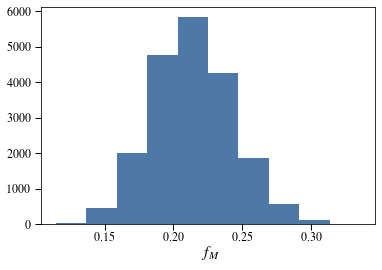

In [8]:
plt.hist(f_Ms)
plt.xlabel(r'$f_M$')

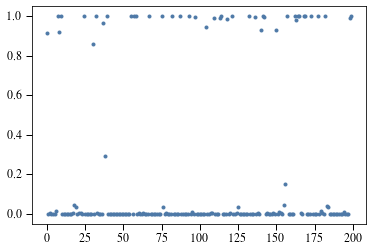

In [23]:
plt.plot(np.arange(n_obj), classif.mean(axis=0), '.')

<ErrorbarContainer object of 3 artists>

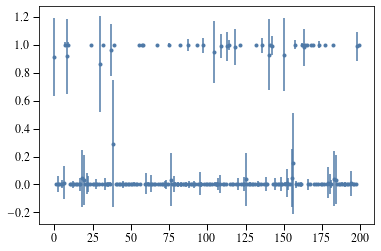

In [32]:
classif.shape

bootstrap = []
for i in range(10000):
    strap = []
    for j in range(n_obj):
        strap.append(np.random.choice(classif[:,j]))
    bootstrap.append(strap)
    
bootstrap = np.array(bootstrap)

plt.errorbar(np.arange(n_obj), classif.mean(axis=0), bootstrap.std(axis=0), fmt='.')

In [40]:
bootstrap.std(axis=0)

array([0.28006849, 0.0099995 , 0.05905718, 0.        , 0.        ,
       0.02827296, 0.117076  , 0.01731791, 0.26989478, 0.01731791,
       0.        , 0.        , 0.02448755, 0.        , 0.        ,
       0.        , 0.        , 0.04577761, 0.20464985, 0.17837486,
       0.0099995 , 0.07658453, 0.05735076, 0.        , 0.        ,
       0.        , 0.        , 0.03603207, 0.0099995 , 0.        ,
       0.34468995, 0.        , 0.        , 0.04354756, 0.        ,
       0.01731791, 0.01414072, 0.18802423, 0.45491071, 0.        ,
       0.        , 0.        , 0.0099995 , 0.        , 0.        ,
       0.02644825, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01414072, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.07528287, 0.01414072, 0.        , 0.0615269 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.02448755, 0.0299865 , 0.     